# gkmsvm comparison analysis

In [1]:
### header ###
__author__ = "Jenhan Tao"
__license__ = "BSD"
__email__ = "jenhantao@gmail.com"

### imports ###
import sys
import os
import pandas as pd
import numpy as np
import argparse
import matplotlib
import itertools
import scipy
import matplotlib.pyplot as plt 
import seaborn as sns
import scipy
import pickle
from sklearn import preprocessing
import sklearn
from sklearn import decomposition
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn import svm, datasets
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, auc
from sklearn import ensemble
from sklearn import neighbors
import matplotlib_venn
from sklearn.cross_validation import train_test_split
from random import shuffle

### notebook specific configuration ###
%matplotlib inline
matplotlib.pylab.rcParams['savefig.dpi'] = 200
sys.setrecursionlimit(5000)
os.chdir('/gpfs/data01/glasslab/home/jtao/analysis/method_comparison_analysis/')
sns.set_context('notebook')
%load_ext autoreload
%autoreload 2
%env PATH=/gpfs/data01/glasslab/home/jtao/perl5/bin:/gpfs/data01/glasslab/home/jtao/software/anaconda3/bin:/home/jtao/software/bin:/usr/local/sbin:/usr/sbin:/usr/bin:/usr/local/bin:/usr/bin:/gpfs/data01/glasslab/home/jtao/software/homer/bin:/gpfs/data01/glasslab/home/jtao/software/weblogo:/home/jtao/code/seq_merge_pipe:/home/vlink/mouse_strains/marge/shifting:/bioinformatics/glassutils/scripts:/bioinformatics/software/meme/bin:/home/jtao/software/lsgkm/bin

env: PATH=/gpfs/data01/glasslab/home/jtao/perl5/bin:/gpfs/data01/glasslab/home/jtao/software/anaconda3/bin:/home/jtao/software/bin:/usr/local/sbin:/usr/sbin:/usr/bin:/usr/local/bin:/usr/bin:/gpfs/data01/glasslab/home/jtao/software/homer/bin:/gpfs/data01/glasslab/home/jtao/software/weblogo:/home/jtao/code/seq_merge_pipe:/home/vlink/mouse_strains/marge/shifting:/bioinformatics/glassutils/scripts:/bioinformatics/software/meme/bin:/home/jtao/software/lsgkm/bin


## Functions

In [2]:
# split data into GC content matched training and test data
def get_GC_matched_split(features, labels, test_size, tolerance = 0.01):
    '''
    feature: 2D array (samples x features)
    labels: 1D boolean array (samples x)
    test_size: fraction of data to test on
    tolerance: max difference in GC content between True and False labelled samples
    '''
    global _id_sequence_dict
    
    ### match GC content of samples labelled True with those labelled False by thowing out False samples
    # retrieve sequences using index of labels
    index_label_tuples = tuple(zip(labels.index.values, labels.values))
    
    true_sequences = [_id_sequence_dict[x[0]] for x in index_label_tuples if x[1]]
    true_ids = [x[0] for x in index_label_tuples if x[1]]
    
    false_sequences = [_id_sequence_dict[x[0]] for x in index_label_tuples if not x[1]]
    false_ids = [x[0] for x in index_label_tuples if not x[1]]
    
    # calculate GC content of True samples
    true_gc_count = 0
    true_length = 0
    for s in true_sequences:
        true_gc_count += s.count('G')
        true_gc_count += s.count('C')
        true_length += len(s)
    true_gc_content = true_gc_count/(true_length+0.0000001)
    
    # calcuate GC content of False samples
    false_gc_count = 0
    false_length = 0
    for s in false_sequences:
        false_gc_count += s.count('G')
        false_gc_count += s.count('C')
        false_length += len(s)
    false_gc_content = false_gc_count/(false_length+0.0000001)
    
    while abs(true_gc_content - false_gc_content) > tolerance:
        # remove false GC sequences until GC content matches tolerance
        selected_seq = False
        
        while not selected_seq:
            rand_index = np.random.randint(len(false_sequences))
            current_seq = false_sequences[rand_index]
            current_gc_count = current_seq.count('G')+ current_seq.count('C')
            current_length = len(current_seq)
            current_gc = current_gc_count/current_length
            if true_gc_content > false_gc_content:
                # remove sequences that would increase overall GC content of False sequences
                if current_gc < false_gc_content:
                    selected_seq = True
            else:
                # remove sequences that would decrease overall GC content of False sequences
                if current_gc > false_gc_content:
                    selected_seq = True
        false_gc_count -= current_gc_count
        false_length -= current_length
        false_gc_content = false_gc_count/false_length
        
        false_sequences.pop(rand_index)
        false_ids.pop(rand_index)
    
    filtered_ids = true_ids + false_ids
    filtered_features = features[features.index.isin(filtered_ids)]
    filtered_labels = labels[labels.index.isin(filtered_ids)]

    if test_size <= 0.5:
        training_indices, test_indices = next(iter(
                sklearn.cross_validation.StratifiedKFold(filtered_labels, int(1/test_size), shuffle=True)))
    else:
        test_indices, training_indices = next(
            iter(sklearn.cross_validation.StratifiedKFold(filtered_labels, int(1/(1-test_size)), shuffle=True)))
    training_ids = [filtered_ids[i] for i in training_indices]
    test_ids = [filtered_ids[i] for i in test_indices]
    
    training_features = filtered_features[filtered_features.index.isin(training_ids)]
    test_features = filtered_features[filtered_features.index.isin(test_ids)]
    training_labels = filtered_labels[filtered_labels.index.isin(training_ids)]
    test_labels = filtered_labels[filtered_labels.index.isin(test_ids)]
    
    return training_features, test_features, training_labels, test_labels
    

## Copy New Files

In [15]:
%%bash
cp /gpfs/data01/glasslab/home/jtao/analysis/cobinding_motif_analysis/motif_score_frame_C57BL6J.pickle ./
cp /gpfs/data01/glasslab/home/jtao/analysis/cobinding_motif_analysis/motif_sequence_frame_C57BL6J.pickle ./
cp /gpfs/data01/glasslab/home/jtao/analysis/cobinding_motif_analysis/motif_strand_frame_C57BL6J.pickle ./
cp /gpfs/data01/glasslab/home/jtao/analysis/cobinding_motif_analysis/motif_start_frame_C57BL6J.pickle ./
cp /gpfs/data01/glasslab/home/jtao/analysis/cobinding_motif_analysis/motif_end_frame_C57BL6J.pickle ./
cp /gpfs/data01/glasslab/home/jtao/analysis/cobinding_motif_analysis/summary_frame.pickle ./
cp /gpfs/data01/glasslab/home/jtao/analysis/cobinding_motif_analysis/annotation_frame.pickle ./
cp /gpfs/data01/glasslab/home/jtao/analysis/cobinding_motif_analysis/peak_sequences/C57BL6J.fa ./


## Read in Score Files

In [16]:
motif_score_frame=pd.read_pickle('motif_score_frame_C57BL6J.pickle')
motif_sequence_frame = pd.read_pickle('motif_sequence_frame_C57BL6J.pickle')
motif_strand_frame = pd.read_pickle('motif_strand_frame_C57BL6J.pickle')
motif_start_frame = pd.read_pickle('motif_start_frame_C57BL6J.pickle')
motif_end_frame = pd.read_pickle('motif_end_frame_C57BL6J.pickle')
summary_frame = pd.read_pickle('summary_frame.pickle')
annotation_frame = pd.read_pickle('annotation_frame.pickle')

scaler = preprocessing.StandardScaler()
standardized_motif_frame = pd.DataFrame(scaler.fit_transform(motif_score_frame.ix[:,3:]))
standardized_motif_frame.columns = motif_score_frame.columns.values[3:]
standardized_motif_frame.index = motif_score_frame.index.values

_factors = sorted(list(set([x.split('_')[1] for x in summary_frame.columns if '_' in x])))
_factors.remove('atac')

### read in sequences as dictionary {peakID: sequence}
with open('./C57BL6J.fa') as f:
    data = f.readlines()

_id_sequence_dict = {}
for line in data:
    if line[0] == '>':
        sequenceName = line.strip()[1:]
    else:
        _id_sequence_dict[sequenceName] = line.strip().upper()    

In [17]:
### work with just intergenic peaks for now ###
intergenic_ids = annotation_frame[annotation_frame['Annotation'] == 'Intergenic'].index.values
intergenic_motif_score_frame = motif_score_frame[motif_score_frame.index.isin(intergenic_ids)]
intergenic_motif_sequence_frame = motif_sequence_frame[motif_sequence_frame.index.isin(intergenic_ids)]
intergenic_motif_start_frame = motif_start_frame[motif_start_frame.index.isin(intergenic_ids)]
intergenic_motif_end_frame = motif_end_frame[motif_end_frame.index.isin(intergenic_ids)]
intergenic_summary_frame = summary_frame[summary_frame.index.isin(intergenic_ids)]
intergenic_annotation_frame = annotation_frame[annotation_frame.index.isin(intergenic_ids)]



In [18]:
ap1_members=['atf3', 'cjun', 'fos', 'junb', 'jund']
contains_ap1 = summary_frame[['c57bl6_'+x+'_veh' for x in ap1_members]].sum(axis=1)>0
contains_ap1_tuples = tuple(zip(contains_ap1.index.values, contains_ap1.values, summary_frame['Factors'].values))
summary_frame['Factors'] = [x[2] + ',c57bl6_ap-1_veh' if x[1] == True else x[2] for x in contains_ap1_tuples]

contains_ap1 = summary_frame[['c57bl6_'+x+'_kla' for x in ap1_members]].sum(axis=1)>0
contains_ap1_tuples = tuple(zip(contains_ap1.index.values, contains_ap1.values, summary_frame['Factors'].values))
summary_frame['Factors'] = [x[2] + ',c57bl6_ap-1_kla' if x[1] == True else x[2] for x in contains_ap1_tuples]

## Run Different Methods

In [19]:
ap1_members = ['atf3','cjun', 'fos', 'junb','jund']    

In [20]:
numIterations = 5
test_size = 0.5

factors = ['atf3','cjun', 'fos', 'junb','jund', 'cebpa', 'pu1', 'atac','p65']


# c57bl6_indices = summary_frame[summary_frame['Factors'].str.contains('c57bl6')].index.values  

### Logistic Regression on Motif Scores

In [21]:
### for all peaks in vehicle for all motifs
factor_auc_dict_lr = {}
factor_precision_dict_lr = {}
factor_coeff_dict = {}

for treatment in ['veh', 'kla']:
    for monomer in ap1_members:
        c57bl6_indices = summary_frame[summary_frame[['c57bl6_' + x + '_' + treatment for x in factors]].sum(axis=1) > 0].index.values  
        features = standardized_motif_frame[standardized_motif_frame.index.isin(c57bl6_indices)]
        labels = summary_frame[summary_frame.index.isin(c57bl6_indices)]['Factors'].str.contains('c57bl6_' + monomer + '_' + treatment)
        
        if np.sum(labels) >= 100:
            all_aucs = []
            all_precisions = []
            all_coeficients = []
            for i in range(numIterations):  

                # split data into training and test sets
                training_features, test_features, training_labels, test_labels = get_GC_matched_split(
                    features, labels, test_size = test_size, tolerance = 0.01)

                #  Run classifier
                lr_classifier = sklearn.linear_model.LogisticRegression(penalty='l1', n_jobs=-1)

                lr_classifier.fit(training_features, training_labels)
                # retrieve probabilities
                probas_lr = lr_classifier.predict_proba(test_features)

                # score predictions
                current_roc_auc = sklearn.metrics.roc_auc_score(test_labels, probas_lr[:, 1])
                current_precision = sklearn.metrics.average_precision_score(test_labels, probas_lr[:, 1])
                current_coefficients = lr_classifier.coef_.flatten()
                
                all_coeficients.append(current_coefficients)
                all_aucs.append(current_roc_auc)
                all_precisions.append(current_precision)

            # average scoring metrics across iterations
            mean_roc_auc = np.mean(all_aucs)
            mean_precision = np.mean(all_precisions)
            mean_coefficients = np.mean(all_coeficients, axis=0) # average coefficients 

            print(monomer + '_' + treatment,
                  'roc:', mean_roc_auc, 
                  'precision:', mean_precision, 
                  'numTestPositives:', np.sum(test_labels)
                 )
            factor_coeff_dict[monomer + '_' + treatment] = mean_coefficients
            factor_auc_dict_lr[monomer + '_' + treatment]= all_aucs
            factor_precision_dict_lr[monomer + '_' + treatment]= all_precisions

atf3_veh roc: 0.837198169311 precision: 0.712985973723 numTestPositives: 11100
cjun_veh roc: 0.812323043374 precision: 0.468716810787 numTestPositives: 6318
fos_veh roc: 0.859480132635 precision: 0.358471519701 numTestPositives: 1049
junb_veh roc: 0.680489196816 precision: 0.0212806273238 numTestPositives: 265
jund_veh roc: 0.808010335973 precision: 0.564164526088 numTestPositives: 9007
atf3_kla roc: 0.830425025031 precision: 0.799720942187 numTestPositives: 17162
cjun_kla roc: 0.806497223241 precision: 0.478950516004 numTestPositives: 8111
fos_kla roc: 0.832273657484 precision: 0.662315720192 numTestPositives: 10694
junb_kla roc: 0.827744766943 precision: 0.476897078391 numTestPositives: 7026
jund_kla roc: 0.819025770433 precision: 0.713672525514 numTestPositives: 15048


### Logistic Regression on AP-1 Motif Score

In [22]:
### for all peaks in vehicle for AP-1 motif
factor_auc_dict_lrAP1only = {}
factor_precision_dict_lrAP1only = {}
treatment = 'veh'
for treatment in ['veh', 'kla']:
    for monomer in ap1_members:
        c57bl6_indices = summary_frame[summary_frame[['c57bl6_' + x + '_' + treatment for x in factors]].sum(axis=1) > 0].index.values  
    #     features = standardized_motif_frame[standardized_motif_frame.index.isin(c57bl6_indices)][['ap-1', 'atf7_batf3_creb5']]
        features = standardized_motif_frame[standardized_motif_frame.index.isin(c57bl6_indices)][['ap-1']]

        labels = summary_frame[summary_frame.index.isin(c57bl6_indices)]['Factors'].str.contains('c57bl6_' + monomer + '_' + treatment)

        if np.sum(labels) >= 100:
            all_aucs = []
            all_precisions = []
            for i in range(numIterations):  

                # split data into training and test sets
                training_features, test_features, training_labels, test_labels = get_GC_matched_split(
                    features, labels, test_size = test_size, tolerance = 0.01)

                #  Run classifier
                lr_classifier = sklearn.linear_model.LogisticRegression(penalty='l1')

                lr_classifier.fit(training_features, training_labels)
                # retrieve probabilities
                probas_lr = lr_classifier.predict_proba(test_features)

                # score predictions
                current_roc_auc = sklearn.metrics.roc_auc_score(test_labels, probas_lr[:, 1], average = None)
                current_precision = sklearn.metrics.average_precision_score(test_labels, probas_lr[:, 1], average = None)

                all_aucs.append(current_roc_auc)
                all_precisions.append(current_precision)


            # average scoring metrics across iterations
            mean_roc_auc = np.mean(all_aucs)
            mean_precision = np.mean(all_precisions)

            print(monomer + '_' + treatment,
                  'roc:', mean_roc_auc, 
                  'precision:', mean_precision,
                  'numTestPositives:', np.sum(test_labels)
                 )
            factor_auc_dict_lrAP1only[monomer + '_' + treatment]= all_aucs
            factor_precision_dict_lrAP1only[monomer + '_' + treatment]= all_precisions


atf3_veh roc: 0.711787583751 precision: 0.637931757196 numTestPositives: 11026
cjun_veh roc: 0.723658166232 precision: 0.496315500838 numTestPositives: 6318
fos_veh roc: 0.642339524359 precision: 0.281640776137 numTestPositives: 983
junb_veh roc: 0.638571887718 precision: 0.172585453724 numTestPositives: 260
jund_veh roc: 0.699381863747 precision: 0.546864876178 numTestPositives: 9032
atf3_kla roc: 0.704110850712 precision: 0.731318073155 numTestPositives: 17375
cjun_kla roc: 0.692280806969 precision: 0.464549817676 numTestPositives: 8164
fos_kla roc: 0.764707637143 precision: 0.650317394266 numTestPositives: 10815
junb_kla roc: 0.726181347832 precision: 0.469460080117 numTestPositives: 7047
jund_kla roc: 0.698968880291 precision: 0.649040359423 numTestPositives: 14896


### Logistic Regression on Balanced Data

In [23]:
### for all peaks in vehicle for all motifs with balanced training data
factor_auc_dict_lrBalanced = {}
factor_precision_dict_lrBalanced = {}

for treatment in ['veh', 'kla']:
    for monomer in ap1_members:
        c57bl6_indices = summary_frame[summary_frame[['c57bl6_' + x + '_' + treatment for x in factors]].sum(axis=1) > 0].index.values  
        features = standardized_motif_frame[standardized_motif_frame.index.isin(c57bl6_indices)]

        labels = summary_frame[summary_frame.index.isin(c57bl6_indices)]['Factors'].str.contains('c57bl6_' + monomer + '_' + treatment)

        if np.sum(labels) > 100:
            all_precisions = []
            all_aucs = []

            for i in range(numIterations):    
                # split data into training and test sets
                training_features, test_features, training_labels, test_labels = get_GC_matched_split(
                    features, labels, test_size = test_size, tolerance = 0.01)
                id_label_tuples = list(zip(training_labels.index.values, training_labels.values))
                id_label_dict = dict(zip(training_labels.index.values, training_labels.values))
                true_ids = [x[0] for x in id_label_tuples if x[1] == True]
                false_ids= [x[0] for x in id_label_tuples if x[1] == False]
                # randomly select as many False IDs randomly as True IDs
                shuffle(false_ids)
                selected_false_ids = false_ids[:len(true_ids)]

                balanced_training_ids = true_ids + selected_false_ids

                balanced_training_features = training_features[training_features.index.isin(balanced_training_ids)]
                balanced_training_labels = pd.Series([id_label_dict[x] for x in balanced_training_features.index.values],
                                                     index= balanced_training_features.index.values)



                #  Run classifier
                lr_classifier = sklearn.linear_model.LogisticRegression(penalty='l1')

                lr_classifier.fit(balanced_training_features, balanced_training_labels)
                # retrieve probabilities
                probas_lr = lr_classifier.predict_proba(test_features)

                # score predictions
                current_roc_auc = sklearn.metrics.roc_auc_score(test_labels, probas_lr[:, 1], average=None)
                current_precision = sklearn.metrics.average_precision_score(test_labels, probas_lr[:, 1], average = None)

                all_aucs.append(current_roc_auc)
                all_precisions.append(current_precision)

            # average scoring metrics across iterations
            mean_roc_auc = np.mean(all_aucs)
            mean_precision = np.mean(all_precisions)

            print(monomer + '_' + treatment,
                  'roc:', mean_roc_auc, 
                  'precision:', mean_precision,
                  'numTestPositives:', np.sum(test_labels)
                 )
            factor_auc_dict_lrBalanced[monomer + '_' + treatment]= all_aucs
            factor_precision_dict_lrBalanced[monomer + '_' + treatment]= all_precisions
    



atf3_veh roc: 0.837505307879 precision: 0.713452848425 numTestPositives: 11020
cjun_veh roc: 0.809917668905 precision: 0.459388380279 numTestPositives: 6241
fos_veh roc: 0.847759202921 precision: 0.315529084799 numTestPositives: 1001
junb_veh roc: 0.629946365358 precision: 0.0180997706455 numTestPositives: 256
jund_veh roc: 0.806552625361 precision: 0.559261094807 numTestPositives: 9006
atf3_kla roc: 0.832533854528 precision: 0.801472253939 numTestPositives: 17265
cjun_kla roc: 0.804874945532 precision: 0.475940264853 numTestPositives: 8012
fos_kla roc: 0.831056627817 precision: 0.658968043094 numTestPositives: 10733
junb_kla roc: 0.826204832005 precision: 0.470891940884 numTestPositives: 7009
jund_kla roc: 0.817715701684 precision: 0.710813899156 numTestPositives: 15035


### Logistic Regression on Top Motifs

In [24]:
coefficient_frame = pd.DataFrame(factor_coeff_dict)
coefficient_frame.index = standardized_motif_frame.columns.values
# transform_coffcients into z-scores
scaler = preprocessing.StandardScaler()
coefficients_standardized_frame = pd.DataFrame(scaler.fit_transform(coefficient_frame))
coefficients_standardized_frame.index = coefficient_frame.index.values
coefficients_standardized_frame.columns = coefficient_frame.columns.values

In [27]:
### for all peaks in vehicle for top motifs
factor_precision_dict_lrTop = {}
factor_auc_dict_lrTop = {}
weight_threshold = 1.0
for treatment in ['veh', 'kla']:
    for monomer in ap1_members:
        c57bl6_indices = summary_frame[summary_frame[['c57bl6_' + x + '_' + treatment for x in factors]].sum(axis=1) > 0].index.values  
        top_motifs = coefficients_standardized_frame[coefficients_standardized_frame[monomer + '_' + treatment].abs() > weight_threshold].index.values
        features = standardized_motif_frame[standardized_motif_frame.index.isin(c57bl6_indices)][top_motifs]

        labels = summary_frame[summary_frame.index.isin(c57bl6_indices)]['Factors'].str.contains('c57bl6_' + monomer + '_' + treatment)

        if np.sum(labels) >= 100:
            all_aucs = []
            all_precisions = []
            for i in range(numIterations):  

                # split data into training and test sets
                training_features, test_features, training_labels, test_labels = get_GC_matched_split(
                    features, labels, test_size = test_size, tolerance = 0.01)

                #  Run classifier
                lr_classifier = sklearn.linear_model.LogisticRegression(penalty='l1')

                lr_classifier.fit(training_features, training_labels)
                # retrieve probabilities
                probas_lr = lr_classifier.predict_proba(test_features)

                # score predictions
                current_roc_auc = sklearn.metrics.roc_auc_score(test_labels, probas_lr[:, 1], average = None)
                current_precision = sklearn.metrics.average_precision_score(test_labels, probas_lr[:, 1], average = None)

                all_aucs.append(current_roc_auc)
                all_precisions.append(current_precision)


            # average scoring metrics across iterations
            mean_roc_auc = np.mean(all_aucs)
            mean_precision = np.mean(all_precisions)

            print(monomer + '_' + treatment,
                  'numMotifs', len(top_motifs),
                  'roc:', mean_roc_auc, 
                  'precision:', mean_precision,
                  'numTestPositives:', np.sum(test_labels)
                 )
            factor_auc_dict_lrTop[monomer + '_' + treatment]= all_aucs
            factor_precision_dict_lrTop[monomer + '_' + treatment]= all_precisions

atf3_veh numMotifs 15 roc: 0.82087271024 precision: 0.69716266686 numTestPositives: 11013
cjun_veh numMotifs 18 roc: 0.796126140187 precision: 0.460166262546 numTestPositives: 6353
fos_veh numMotifs 37 roc: 0.869091333207 precision: 0.363580724454 numTestPositives: 970
junb_veh numMotifs 54 roc: 0.735768701168 precision: 0.030679278677 numTestPositives: 259
jund_veh numMotifs 19 roc: 0.783227634592 precision: 0.547773332296 numTestPositives: 9094
atf3_kla numMotifs 18 roc: 0.799503203966 precision: 0.772595319392 numTestPositives: 17277
cjun_kla numMotifs 18 roc: 0.774806640827 precision: 0.443933312429 numTestPositives: 8035
fos_kla numMotifs 12 roc: 0.801616703764 precision: 0.617958467924 numTestPositives: 10677
junb_kla numMotifs 34 roc: 0.812137632466 precision: 0.46202848449 numTestPositives: 7018
jund_kla numMotifs 16 roc: 0.77503804008 precision: 0.666367819932 numTestPositives: 15021


### gkmSVM (Gapped K-mer SVM)

In [30]:
!if [ ! -d ./gkmsvm_files ]; then mkdir ./gkmsvm_files; fi
! rm ./gkmsvm_files/*

In [ ]:
### for all peaks in vehicle using gapped k-mers on balanced data
### write script
factor_auc_dict_gkmSVM = {}
factor_precision_dict_gkmSVM = {}



for treatment in ['veh', 'kla']:
    script_file = open('gkmsvm_' + treatment + '_balanced.sh', 'w')
    for monomer in ap1_members:
        c57bl6_indices = summary_frame[summary_frame[['c57bl6_' + x + '_' + treatment for x in factors]].sum(axis=1) > 0].index.values  
        features = standardized_motif_frame[standardized_motif_frame.index.isin(c57bl6_indices)]

        labels = summary_frame[summary_frame.index.isin(c57bl6_indices)]['Factors'].str.contains('c57bl6_' + monomer + '_' + treatment)

        if np.sum(labels) > 100:
            print(monomer + '_' + treatment)
            all_aucs = []
            all_precisions = []
            for iteration in range(numIterations):  
                # split data into training and test sets
                training_features, test_features, training_labels, test_labels = get_GC_matched_split(
                    features, labels, test_size = test_size, tolerance = 0.01)

                # create fasta files for positive and negative sequences
                training_positive_path = './gkmsvm_files/' + monomer + '_' + treatment+ '_training_positive_balanced_' +str(iteration) + '.fa'
                training_negative_path = './gkmsvm_files/' + monomer + '_' + treatment+ '_training_negative_balanced_' +str(iteration) + '.fa'
                training_shortNegative_path = './gkmsvm_files/' + monomer + '_' + treatment+ '_training_shortNegative_balanced_' +str(iteration) + '.fa'


                training_positive_file = open(training_positive_path,'w' )
                training_negative_file = open(training_negative_path,'w' )
                training_shortNegative_file = open(training_shortNegative_path,'w' )
                test_path = './gkmsvm_files/' + monomer + '_' + treatment+ '_test_balanced_' + str(iteration) + '.fa'

                test_file = open(test_path,'w')

                numPositiveSeqs = np.sum(training_labels)
                count=0
                for i in range(len(training_labels)):
                    index = training_labels.index[i]
                    label = training_labels[i]
                    seq = _id_sequence_dict[index]

                    if label == True:
                        training_positive_file.write('>' + index + '\n')
                        training_positive_file.write(seq + '\n')
                    else:
                        if count < numPositiveSeqs:
                            training_shortNegative_file.write('>' + index + '\n')
                            training_shortNegative_file.write(seq + '\n')
                        training_negative_file.write('>' + index + '\n')
                        training_negative_file.write(seq + '\n')
                        count+=1

                for i in range(len(test_labels)):
                    index = test_labels.index[i]
                    label = test_labels[i]
                    seq = _id_sequence_dict[index]
                    test_file.write('>' + index + '\n')
                    test_file.write(seq + '\n')

                training_positive_file.close()
                training_negative_file.close()
                training_shortNegative_file.close()
                test_file.close()

                #  Run classifier
                model_prefix = './gkmsvm_files/' + monomer + '_' + treatment + '_' +str(iteration) + '_balanced'
                model_path = model_prefix + '.model.txt'
                results_path = model_prefix + '_results.txt'

                script_file.write('(gkmtrain '+ training_positive_path + ' ' + training_shortNegative_path + ' ' + model_prefix +
                          ' -T 16 -m 64000;')
                if iteration == (numIterations - 1):
                    script_file.write('gkmpredict '+ test_path + ' ' + model_path + ' ' +  results_path + ' -T 4)\n')
                else:
                    script_file.write('gkmpredict '+ test_path + ' ' + model_path + ' ' +  results_path + ' -T 4)&\n')
                

    script_file.close()

atf3_veh
cjun_veh
fos_veh
junb_veh
jund_veh
atf3_kla
cjun_kla
fos_kla
junb_kla
jund_kla


In [ ]:
%%bash
chmod a+x ./gkmsvm_veh_balanced.sh 
./gkmsvm_veh_balanced.sh


In [ ]:
%%bash
chmod a+x ./gkmsvm_kla_balanced.sh 
./gkmsvm_kla_balanced.sh

In [ ]:
### for all peaks in vehicle using gapped k-mers on balanced data
### read performance
for treatment in ['veh', 'kla']:
    for monomer in ap1_members:
        c57bl6_indices = summary_frame[summary_frame[['c57bl6_' + x + '_' + treatment for x in factors]].sum(axis=1) > 0].index.values  
        features = standardized_motif_frame[standardized_motif_frame.index.isin(c57bl6_indices)]

        labels = summary_frame[summary_frame.index.isin(c57bl6_indices)]['Factors'].str.contains('c57bl6_' + monomer + '_' + treatment)

        if np.sum(labels) > 100:
            print(monomer + '_' + treatment)
            all_aucs = []
            all_precisions = []
            for iteration in range(numIterations):  
                model_prefix = './gkmsvm_files/' + monomer  + '_' + treatment+ '_' +str(iteration) + '_balanced'
                results_path = model_prefix + '_results.txt'


                index_score_dict = {} #{peakID: gkmSVM score}
                with open(results_path) as f:
                    data = f.readlines()
                for line in data:
                    tokens=line.strip().split()
                    score = float(tokens[1])
                    index = tokens[0]
                    index_score_dict[index] = score
                # define true labels
                index_label_dict = dict(zip(labels.index.values, labels.values))

                sorted_indices = sorted(index_score_dict.keys())

                sorted_scores = np.array([index_score_dict[x] for x in sorted_indices])
                test_labels = np.array([index_label_dict[x] for x in sorted_indices])

                min_score = np.min(sorted_scores)
                if min_score < 0:
                    normalized_scores = sorted_scores + abs(min_score)
                normalized_scores = normalized_scores/np.max(normalized_scores)

                # score predictions          
                current_roc_auc = sklearn.metrics.roc_auc_score(test_labels, normalized_scores, average = None)
                current_precision = sklearn.metrics.average_precision_score(test_labels, normalized_scores, average = None)
                all_precisions.append(current_precision)
                all_aucs.append(current_roc_auc)

            # average scoring metrics 

            mean_roc_auc = np.mean(all_aucs) 
            mean_precision = np.mean(all_precisions)

            factor_auc_dict_gkmSVM[monomer + '_' + treatment]= all_aucs
            factor_precision_dict_gkmSVM[monomer + '_' + treatment]= all_precisions

            print(monomer + '_' + treatment,
                  'roc:', mean_roc_auc, 
                  'precision:', mean_precision,
                  'numTestPositives:', np.sum(test_labels)
                 )



In [ ]:
### for all peaks in vehicle using gapped k-mers on unbalanced data
### write script

factor_auc_dict_unbalancedgkmSVM = {}
factor_precision_dict_unbalancedgkmSVM = {}
for treatment in ['veh', 'kla']:
    script_file = open('gkmsvm_' + treatment +'_unbalanced.sh', 'w')
    for monomer in ap1_members:
        c57bl6_indices = summary_frame[summary_frame[['c57bl6_' + x + '_' + treatment for x in factors]].sum(axis=1) > 0].index.values  
        features = standardized_motif_frame[standardized_motif_frame.index.isin(c57bl6_indices)]
        labels = summary_frame[summary_frame.index.isin(c57bl6_indices)]['Factors'].str.contains('c57bl6_' + monomer + '_' + treatment)

        if np.sum(labels) > 100:
            all_aucs = []
            all_precisions = []

            for iteration in range(numIterations):    
    #         for iteration in [0]:
                # split data into training and test sets
                # !!!features are not used - calculated so get GC matched split will operate!!!
                training_features, test_features, training_labels, test_labels = get_GC_matched_split(
                    features, labels, test_size = test_size, tolerance = 0.01)

                # create fasta files for positive and negative sequences
                training_positive_path = './gkmsvm_files/' + monomer + '_' + treatment + '_training_positive_unbalanced_' +str(iteration) + '.fa'
                training_negative_path = './gkmsvm_files/' + monomer + '_' + treatment + '_training_negative_unbalanced_' +str(iteration) + '.fa'

                training_positive_file = open(training_positive_path,'w' )
                training_negative_file = open(training_negative_path,'w' )
                test_path = './gkmsvm_files/' + monomer  + '_' + treatment + '_test_' + str(iteration) + '.fa'

                test_file = open(test_path,'w')

                numPositiveSeqs = np.sum(training_labels)
                count=0
                for i in range(len(training_labels)):
                    index = training_labels.index[i]
                    label = training_labels[i]
                    seq = _id_sequence_dict[index]
                    if label == True:
                        training_positive_file.write('>' + index + '\n')
                        training_positive_file.write(seq + '\n')
                    else:
                        training_negative_file.write('>' + index + '\n')
                        training_negative_file.write(seq + '\n')
                        count+=1

                for i in range(len(test_labels)):
                    index = test_labels.index[i]
                    label = test_labels[i]
                    seq = _id_sequence_dict[index]
                    test_file.write('>' + index + '\n')
                    test_file.write(seq + '\n')

                training_positive_file.close()
                training_negative_file.close()

                test_file.close()

                #  Run classifier
                model_prefix = './gkmsvm_files/' + monomer + '_' + treatment + '_' +str(iteration) + '_unbalanced'
                model_path = model_prefix + '.model.txt'
                results_path = model_prefix + '_results.txt'

                script_file.write('(gkmtrain '+ training_positive_path + ' ' + training_negative_path + ' ' + model_prefix +
                          ' -T 16 -m 64000;')
                if iteration == (numIterations - 1):
                    script_file.write('gkmpredict '+ test_path + ' ' + model_path + ' ' +  results_path + ' -T 4)\n')
                else:
                    script_file.write('gkmpredict '+ test_path + ' ' + model_path + ' ' +  results_path + ' -T 4)&\n')

    script_file.close()



In [ ]:
%%bash
chmod a+x ./gkmsvm_veh_unbalanced.sh 
./gkmsvm_veh_unbalanced.sh

In [ ]:
%%bash
chmod a+x ./gkmsvm_kla_unbalanced.sh
./gkmsvm_kla_unbalanced.sh

In [ ]:
### for all peaks in vehicle using gapped k-mers on balanced data
### read performance
for treatment in ['veh', 'kla']:
    for monomer in ap1_members:
        c57bl6_indices = summary_frame[summary_frame[['c57bl6_' + x + '_' + treatment for x in factors]].sum(axis=1) > 0].index.values  
        features = standardized_motif_frame[standardized_motif_frame.index.isin(c57bl6_indices)]

        labels = summary_frame[summary_frame.index.isin(c57bl6_indices)]['Factors'].str.contains('c57bl6_' + monomer + '_' + treatment)

        if np.sum(labels) > 100:
            print(monomer + '_' + treatment)
            all_aucs = []
            all_precisions = []
            for iteration in range(numIterations):  
                model_prefix = './gkmsvm_files/' + monomer + '_' + treatment + '_' +str(iteration) + '_unbalanced'
                results_path = model_prefix + '_results.txt'


                index_score_dict = {} #{peakID: gkmSVM score}
                with open(results_path) as f:
                    data = f.readlines()
                for line in data:
                    tokens=line.strip().split()
                    score = float(tokens[1])
                    index = tokens[0]
                    index_score_dict[index] = score
                # define true labels
                index_label_dict = dict(zip(labels.index.values, labels.values))

                sorted_indices = sorted(index_score_dict.keys())

                sorted_scores = np.array([index_score_dict[x] for x in sorted_indices])
                test_labels = np.array([index_label_dict[x] for x in sorted_indices])

                min_score = np.min(sorted_scores)
                if min_score < 0:
                    normalized_scores = sorted_scores + abs(min_score)
                normalized_scores = normalized_scores/np.max(normalized_scores)

                # score predictions          
                current_roc_auc = sklearn.metrics.roc_auc_score(test_labels, normalized_scores, average = None)
                current_precision = sklearn.metrics.average_precision_score(test_labels, normalized_scores, average = None)
                all_precisions.append(current_precision)
                all_aucs.append(current_roc_auc)

            # average scoring metrics 

            mean_roc_auc = np.mean(all_aucs) 
            mean_precision = np.mean(all_precisions)

            factor_auc_dict_unbalancedgkmSVM[monomer + '_' + treatment]= all_aucs
            factor_precision_dict_unbalancedgkmSVM[monomer + '_' + treatment]= all_precisions

            print(monomer + '_' + treatment,
                  'roc:', mean_roc_auc, 
                  'precision:', mean_precision,
                  'numTestPositives:', np.sum(test_labels)
                 )




## Classifier Performance

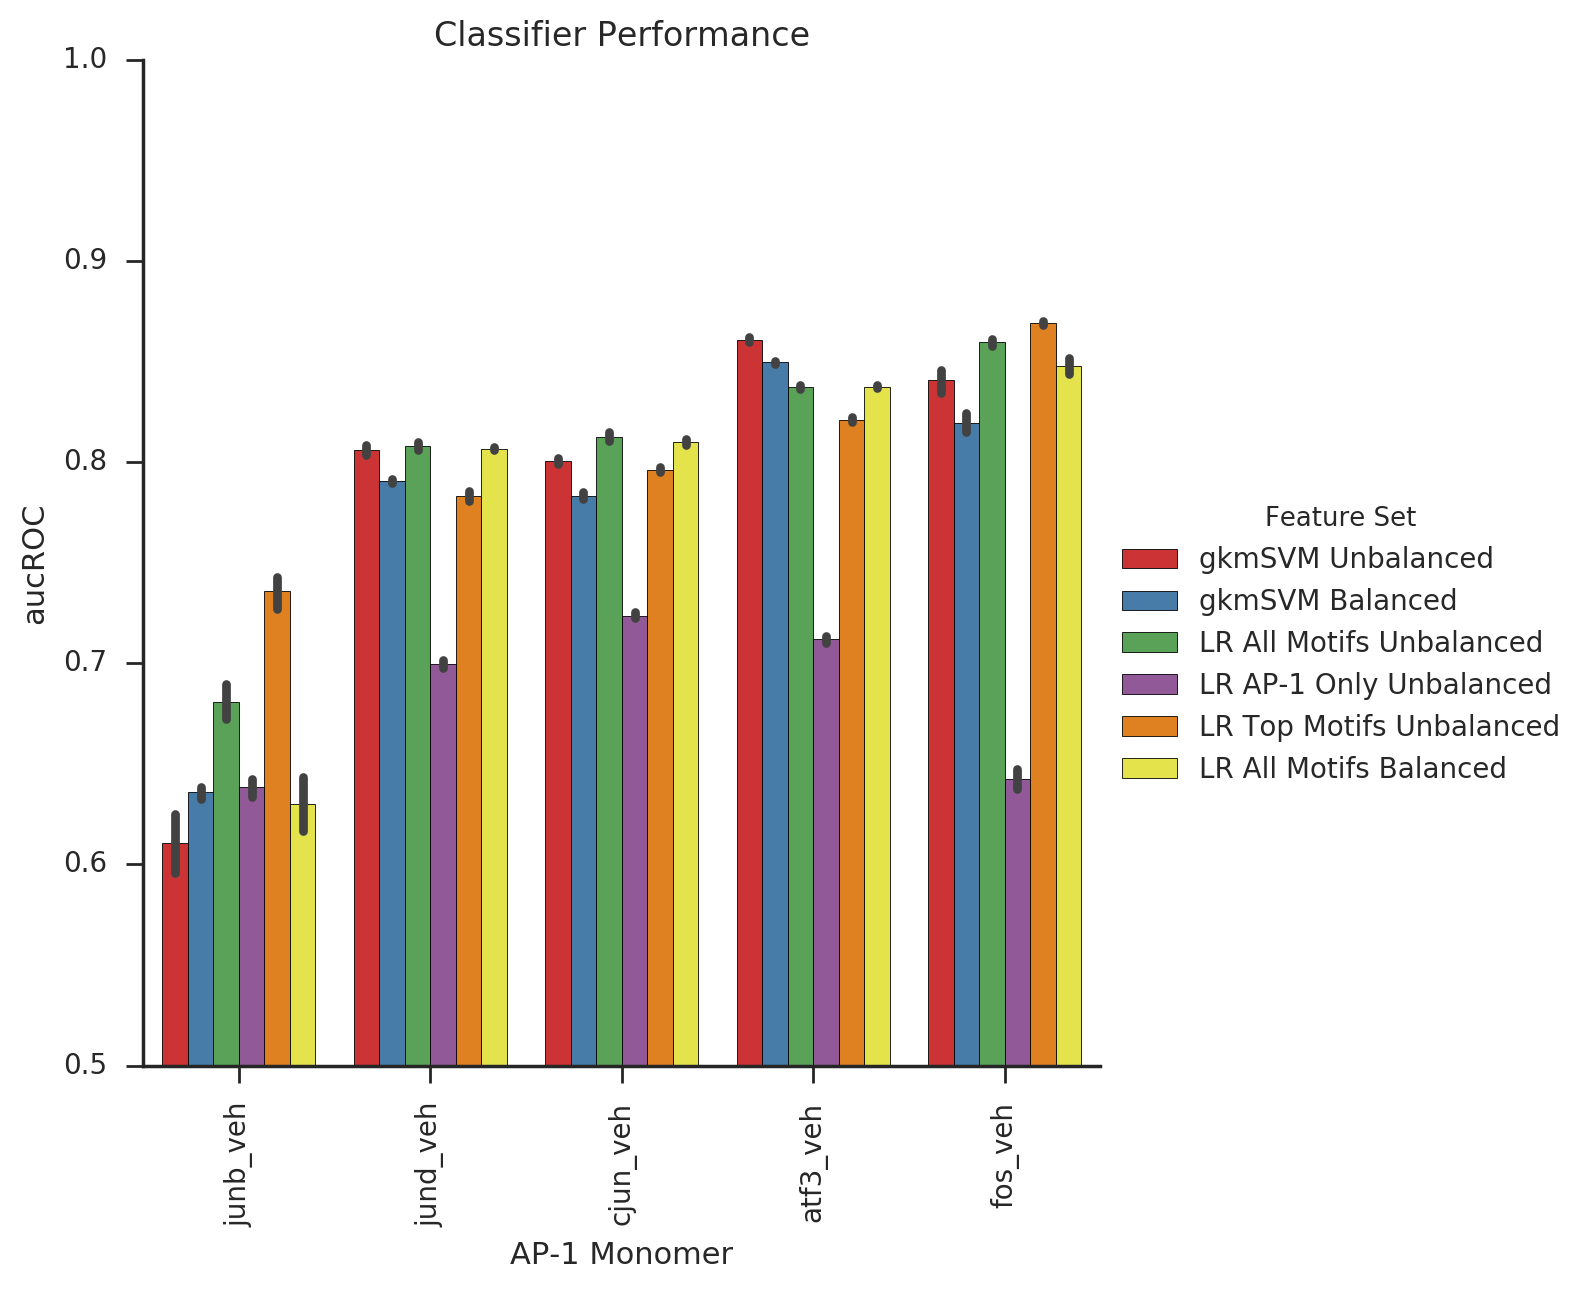

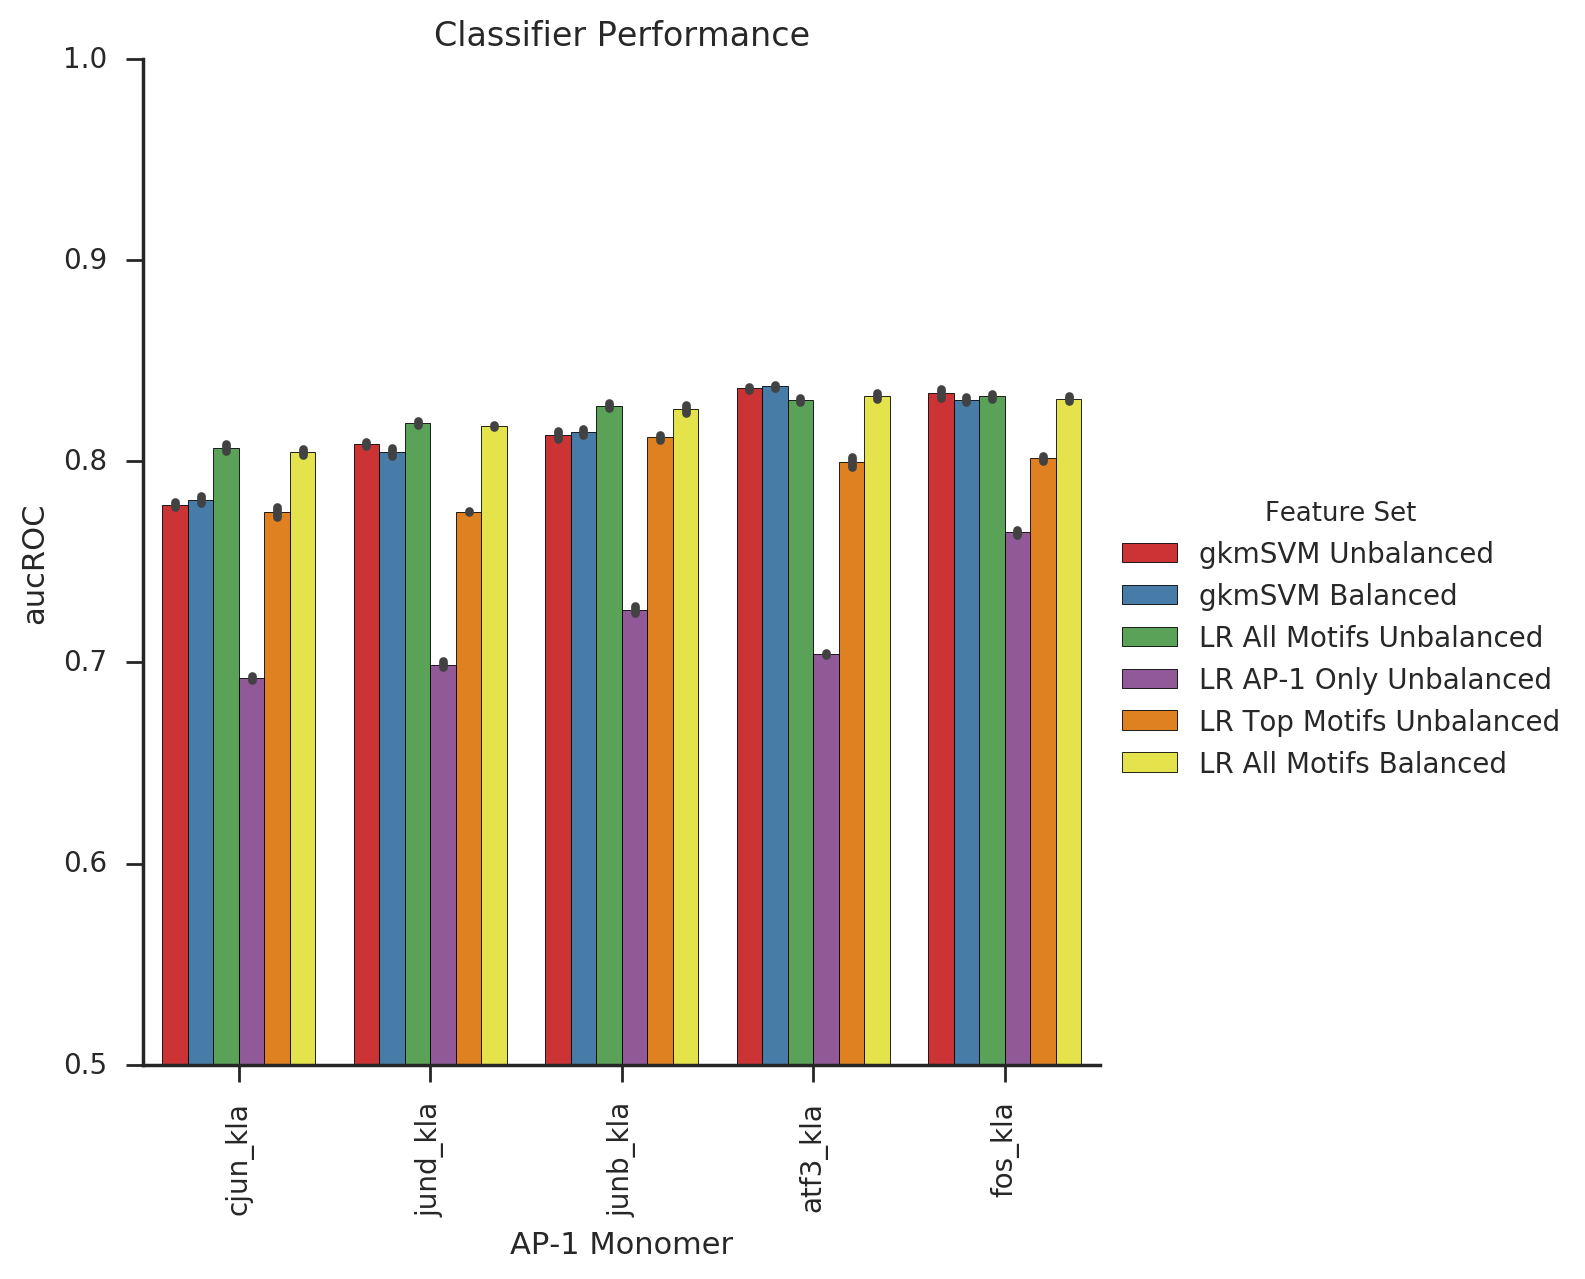

In [48]:
monomers = []
aucs = []
feature_set = []
for monomer in sorted(factor_auc_dict_lr.keys()):
        
    monomers = monomers + numIterations * [monomer]
    aucs = aucs + factor_auc_dict_unbalancedgkmSVM[monomer]
    feature_set = feature_set + numIterations * ['gkmSVM Unbalanced']
    
    monomers = monomers + numIterations * [monomer]
    aucs = aucs + factor_auc_dict_gkmSVM[monomer]
    feature_set = feature_set + numIterations * ['gkmSVM Balanced']
    
    monomers = monomers + numIterations * [monomer]
    aucs = aucs + factor_auc_dict_lr[monomer]
    feature_set = feature_set + numIterations * ['LR All Motifs Unbalanced']
    
    monomers = monomers + numIterations * [monomer]
    aucs = aucs + factor_auc_dict_lrAP1only[monomer]
    feature_set = feature_set + numIterations * ['LR AP-1 Only Unbalanced']
    
    monomers = monomers + numIterations * [monomer]
    aucs = aucs + factor_auc_dict_lrTop[monomer]
    feature_set = feature_set + numIterations * ['LR Top Motifs Unbalanced']
    
    monomers = monomers + numIterations * [monomer]
    aucs = aucs + factor_auc_dict_lrBalanced[monomer]
    feature_set = feature_set + numIterations * ['LR All Motifs Balanced']

    
data = pd.DataFrame({'Factor':monomers,
                     'AUC':aucs,
                     'Feature Set': feature_set
                     })

# Vehicle plot
# sort monomers according to ascending AUC with all motifs
for treatment in ['veh', 'kla']:
    factor_auc_tuples = [(x, np.mean(factor_auc_dict_lr[x])) for x in factor_auc_dict_lr if treatment in x]

    sorted_monomers = [y[0] for y in sorted(factor_auc_tuples, key=lambda x:x[1])]

    with sns.axes_style('ticks'):
        plottingFrame = sns.factorplot(data = data[data['Factor'].str.contains(treatment)],
                                    x='Factor',
                                    y='AUC',
                                    order = sorted_monomers,
                                    palette='Set1',
                                    size=6,
                                    hue='Feature Set',
                                    kind = 'bar')
        sns.despine()
        plt.xticks(rotation=90)
        plt.ylabel('aucROC')
        plt.xlabel('AP-1 Monomer')
        plt.ylim(0.5,1)
        plt.title('Classifier Performance')
        plt.show()



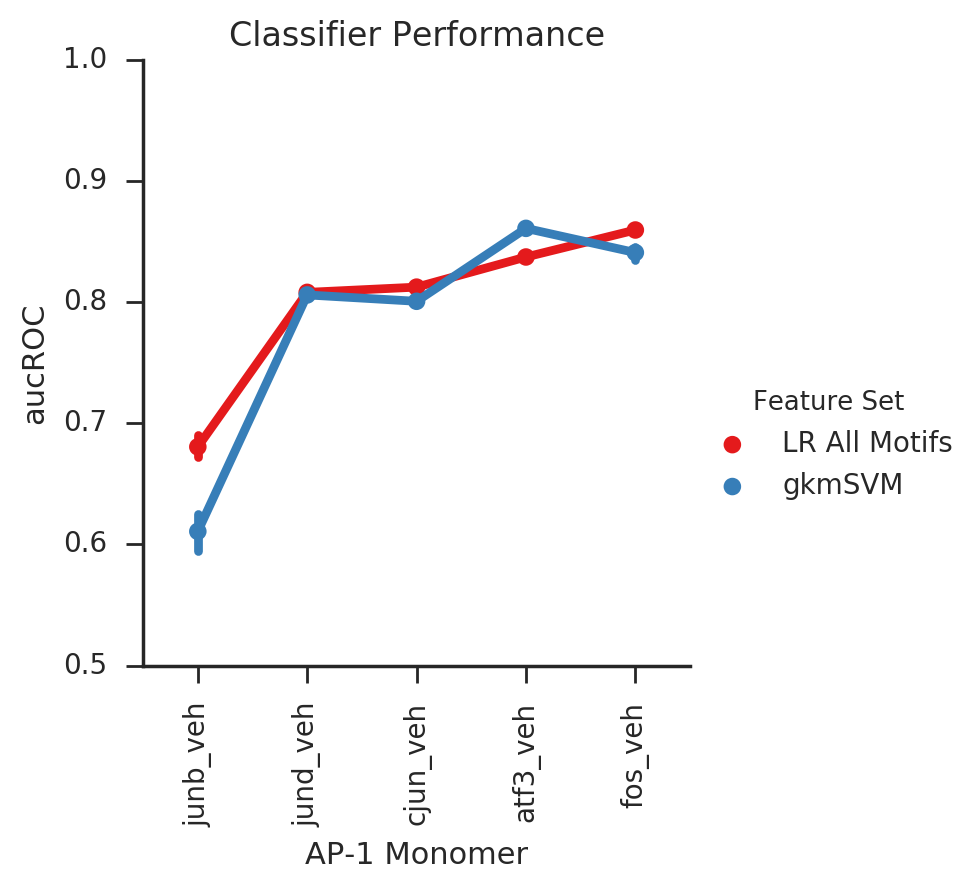

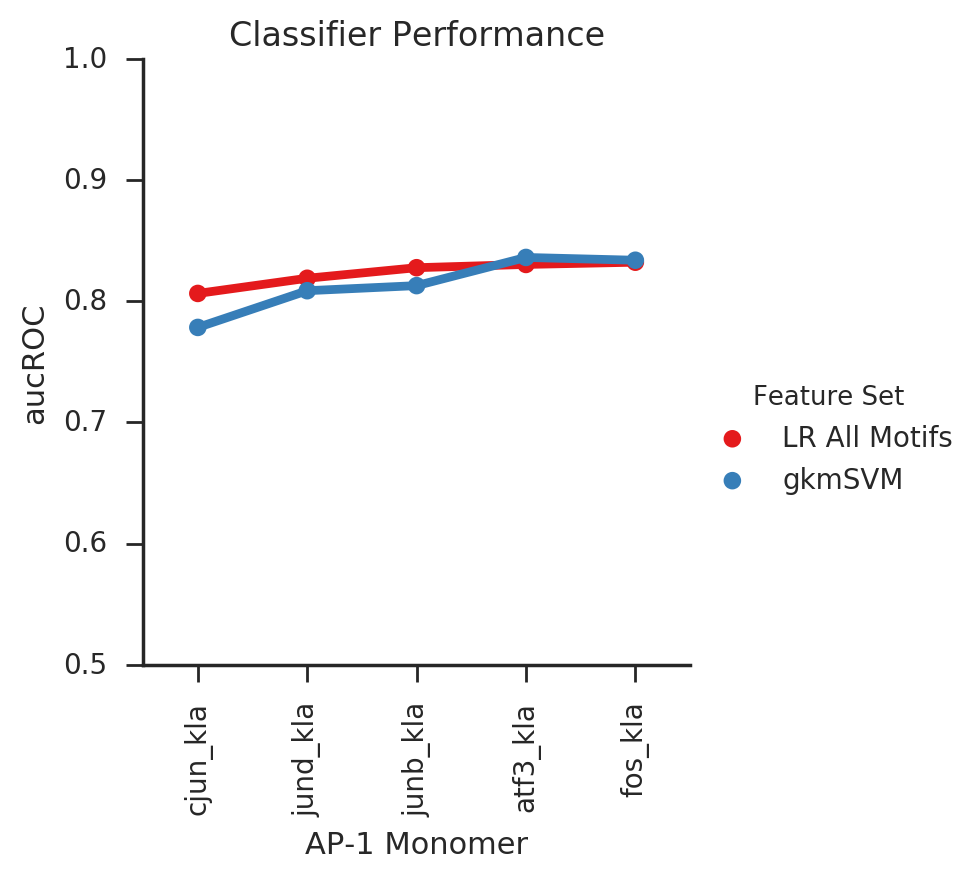

In [54]:
monomers = []
aucs = []
feature_set = []
for factor in sorted(factor_auc_dict_lr.keys()):
    monomers = monomers + numIterations * [factor]
    aucs = aucs + factor_auc_dict_lr[factor]
    feature_set = feature_set + numIterations * ['LR All Motifs']
    
    monomers = monomers + numIterations * [factor]
    aucs = aucs + factor_auc_dict_unbalancedgkmSVM[factor]
    feature_set = feature_set + numIterations * ['gkmSVM']
    
data = pd.DataFrame({'Factor':monomers,
                     'AUC':aucs,
                     'Feature Set': feature_set
                     })

# vehicle plot


for treatment in ['veh', 'kla']:
    factor_auc_tuples = [(x, np.mean(factor_auc_dict_lr[x])) for x in factor_auc_dict_lr if treatment in x]
    sorted_monomers = [y[0] for y in sorted(factor_auc_tuples, key=lambda x:x[1])]
    with sns.axes_style('ticks'):
        plottingFrame = sns.factorplot(data = data[data['Factor'].str.contains(treatment)],
                                    x='Factor',
                                    y='AUC',
                                    order = sorted_monomers,
                                    palette='Set1',
                                    size=4,
                                    hue='Feature Set',
                                    kind = 'point', 
                                    markers = '.', s='0.01')
        sns.despine()
        plt.xticks(rotation=90)
        plt.ylabel('aucROC')
        plt.xlabel('AP-1 Monomer')
        plt.ylim(0.5,1)
        plt.title('Classifier Performance')
        plt.show()

    

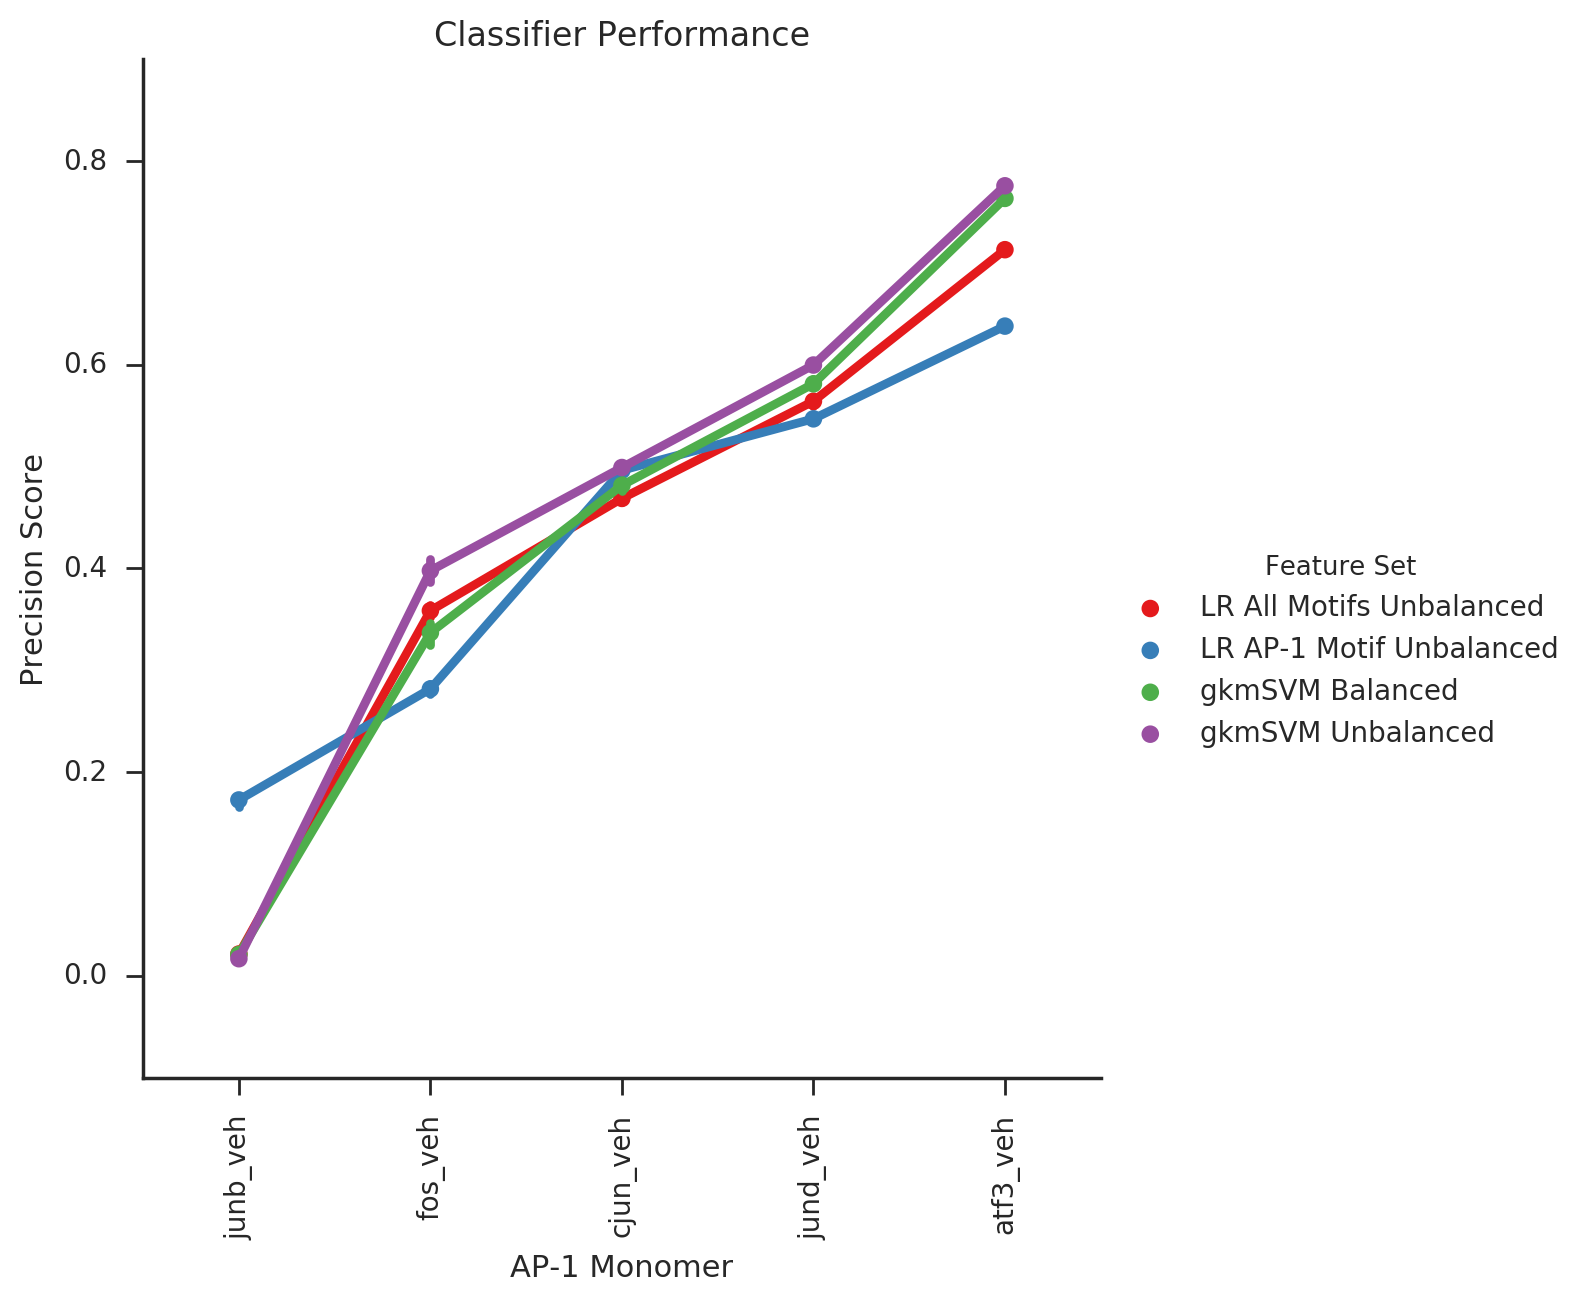

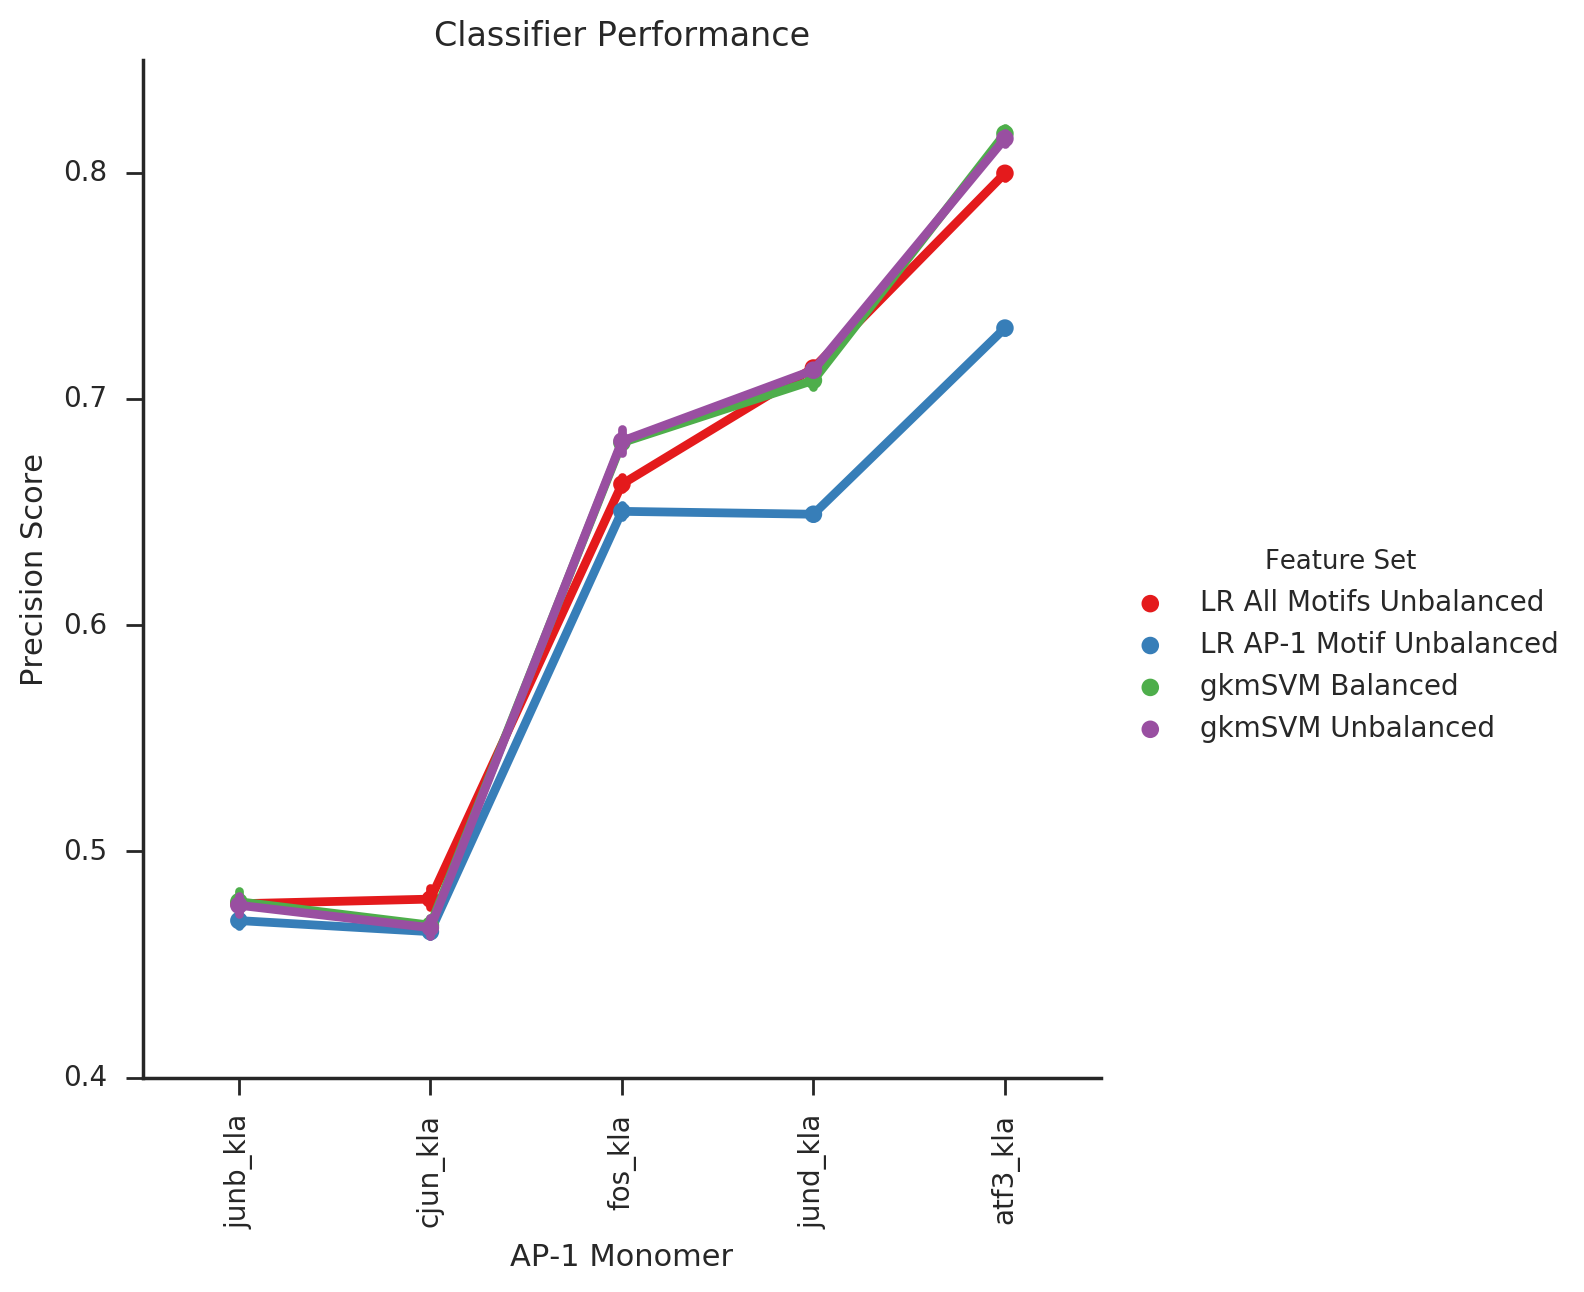

In [52]:
monomers = []
precisions = []
feature_set = []
for factor in sorted(factor_precision_dict_lr.keys()):
    monomers = monomers + numIterations * [factor]
    precisions = precisions + factor_precision_dict_lr[factor]
    feature_set = feature_set + numIterations * ['LR All Motifs Unbalanced']

    monomers = monomers + numIterations * [factor]
    precisions = precisions + factor_precision_dict_lrAP1only[factor]
    feature_set = feature_set + numIterations * ['LR AP-1 Motif Unbalanced']
    
#     monomers = monomers + numIterations * [factor]
#     precisions = precisions + factor_precision_dict_lrBalanced[factor]
#     feature_set = feature_set + numIterations * ['LR All Motifs Balanced']
    
#     monomers = monomers + numIterations * [factor]
#     precisions = precisions + factor_precision_dict_lrTop[factor]
#     feature_set = feature_set + numIterations * ['LR Top Motifs']
    
    monomers = monomers + numIterations * [factor]
    precisions = precisions + factor_precision_dict_gkmSVM[factor]
    feature_set = feature_set + numIterations * ['gkmSVM Balanced']
    
    monomers = monomers + numIterations * [factor]
    precisions = precisions + factor_precision_dict_unbalancedgkmSVM[factor]
    feature_set = feature_set + numIterations * ['gkmSVM Unbalanced']
    
data = pd.DataFrame({'Factor':monomers,
                     'Precision Score':precisions,
                     'Feature Set': feature_set
                     })

for treatment in ['veh', 'kla']:
    # sort monomers according to ascending precision with all motifs
    factor_precision_tuples = [(x, np.mean(factor_precision_dict_lr[x])) for x in factor_precision_dict_lr if treatment in x]

    sorted_monomers = [y[0] for y in sorted(factor_precision_tuples, key=lambda x:x[1])]

    with sns.axes_style('ticks'):
        plottingFrame = sns.factorplot(data = data[data['Factor'].str.contains(treatment)],
                                    x='Factor',
                                    y='Precision Score',
                                    order = sorted_monomers,
                                    palette='Set1',
                                    size=6,
                                    hue='Feature Set',
                                    kind = 'point', 
                                    markers = '.', s='0.01')
        sns.despine()
        plt.xticks(rotation=90)
        plt.ylabel('Precision Score')
        plt.xlabel('AP-1 Monomer')
        plt.title('Classifier Performance')
        plt.show()

    